# Install the required packages

In [ ]:
!pip install transformers sentencepiece

# Load the Donut model

In [1]:
import torch

device = "cpu"
# Use mps if available
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"

In [3]:
from transformers import VisionEncoderDecoderModel, DonutProcessor

checkpoint_name = "naver-clova-ix/donut-base-finetuned-docvqa"

model = VisionEncoderDecoderModel.from_pretrained(checkpoint_name).to(device)
processor = DonutProcessor.from_pretrained(checkpoint_name)

# Load document

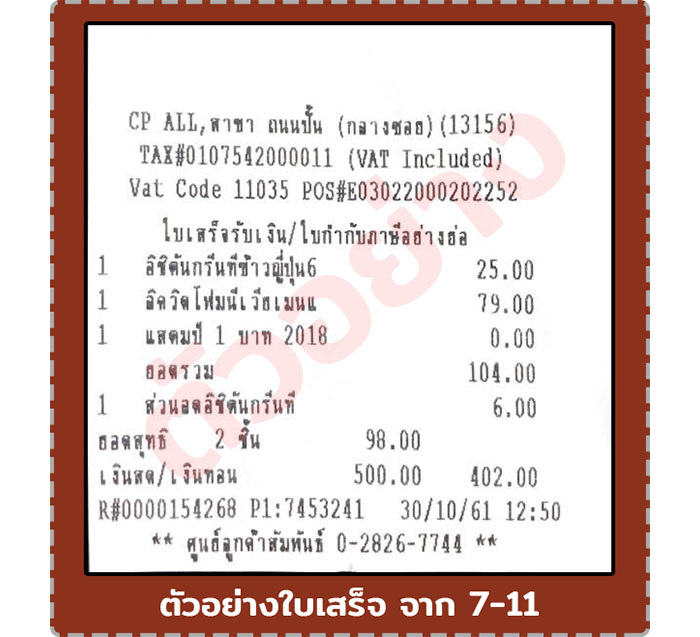

In [4]:
from PIL import Image

image = Image.open("assets/7-11_bill.jpeg").convert("RGB")

display(image)

# Run inference

In [7]:
import re

question = "เบอร์โทรศัพท์ของ ศูนย์ลูกค้าสัมพันธ์ คืออะไร"

task_prompt = "<s_docvqa><s_question>{user_input}</s_question><s_answer>"
prompt = task_prompt.replace("{user_input}", question)
decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids

pixel_values = processor(image, return_tensors="pt").pixel_values

outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(processor.token2json(sequence))

{'question': '<unk>ศัพท์<unk> <unk>สัม<unk> <unk>', 'answer': 'management'}
